# **Advanced Lane Finding Project** 
***
The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


[//]: # (Image References)

[image1]: ./examples/undistort_output.png "Undistorted"
[image2]: ./test_images/test1.jpg "Road Transformed"
[image3]: ./examples/binary_combo_example.jpg "Binary Example"
[image4]: ./examples/warped_straight_lines.jpg "Warp Example"
[image5]: ./examples/color_fit_lines.jpg "Fit Visual"
[image6]: ./examples/example_output.jpg "Output"
[video1]: ./project_video.mp4 "Video"

## [Rubric](https://review.udacity.com/#!/rubrics/571/view) Points
###Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  


### Writeup / README

#### 1. Provide a Writeup / README that includes all the rubric points and how you addressed each one.  

This is the Writeup / README file.

### Camera Calibration

#### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

The code for this step is contained in the first code cell of the IPython notebook.  

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

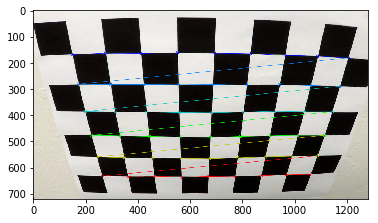

In [2]:
# Read in a calibration image
img = mpimg.imread('./camera_cal/calibration2.jpg')
plt.imshow(img)

# Arrays to store object points and image points from all the images

xPoints = 9
yPoints = 6

objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# Prepare object points, like (0, 0, 0), (1, 0, 0), (2, 0, 0) ...,(7, 5 , 0)
objp = np.zeros((yPoints*xPoints,3), np.float32)
objp[:,:2] = np.mgrid[0:xPoints, 0:yPoints].T.reshape(-1,2) #x,  y coordinates

# Convert image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (xPoints, yPoints), None)

# If corners are found, add objectpoints, image points
if ret == True:
    
    imgpoints.append(corners)
    objpoints.append(objp)

    # draw and display the corners
    img = cv2.drawChessboardCorners(img, (xPoints, yPoints), corners, ret)
    plt.imshow(img)
    


I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I applied this distortion correction to the test image using the `cv2.undistort()` function and obtained this result: 

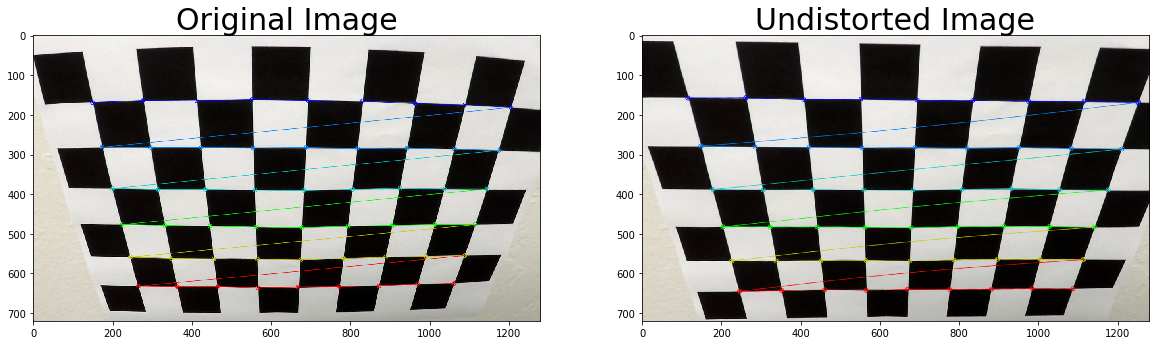

In [3]:
import pickle
%matplotlib inline

# Test undistortion on an image
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "output_images/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

### Pipeline (single images)

The pipeline will be organsied as follow: 
`process_image` is the overall pipeline function that will be used process the video.

Please note, the below cell have dependency on the 6 sections which contain the implementation detail of the functions.

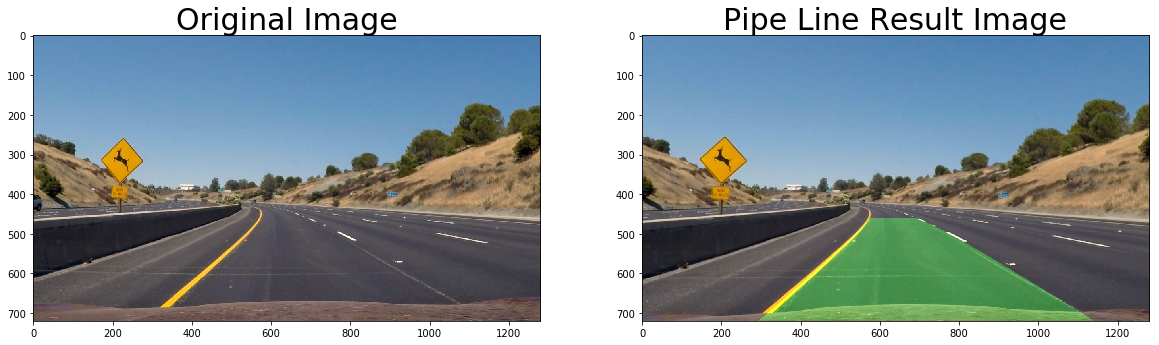

In [17]:
src = np.float32(
    [[(img_size[0] / 2) - 60, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 65), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

def process_image(input_image):
    # Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
    
    # Apply a distortion correction to raw images.
    undist_img = undistort(input_image)
    
    # Use color transforms, gradients, etc., to create a thresholded binary image.
    threshold_binary_image_tmp = threshold_binary(undist_img)

    # Apply a perspective transform to rectify binary image ("birds-eye view").
    perspective_transform_image_tmp = perspective_transform(threshold_binary_image_tmp, src, dst)
    
    # Detect lane pixels and fit to find the lane boundary.
    left_fitx_tmp, right_fitx_tmp, ploty_tmp = prepare_for_plot(perspective_transform_image_tmp)
    
    # Determine the curvature of the lane and vehicle position with respect to center.
    left_curverad_tmp, right_curverad_tmp = curvature(left_fitx_tmp, right_fitx_tmp, ploty_tmp)
    
    # Warp the detected lane boundaries back onto the original image.
    Minv_tmp = cv2.getPerspectiveTransform(dst, src)
    processed_image = draw_green_line(perspective_transform_image_tmp, undist_img, Minv_tmp, left_fitx_tmp, right_fitx_tmp, ploty_tmp)
    
    # Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
    
    return processed_image

# laneImage = mpimg.imread('./test_images/sampleTest.jpg')
laneImage = mpimg.imread('./test_images/test2.jpg')
processedImage = process_image(laneImage)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(laneImage)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(processedImage)
ax2.set_title('Pipe Line Result Image', fontsize=30)

#### 1. Provide an example of a distortion-corrected image.
To demonstrate this step, I will read the stored camera calibration from previous step, and then apply the correction to one of the test images like this one:

In [5]:
def undistort(image):
    with open("output_images/wide_dist_pickle.p", mode='rb') as f:
        dist_pickle = pickle.load(f)

    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    return undist

True

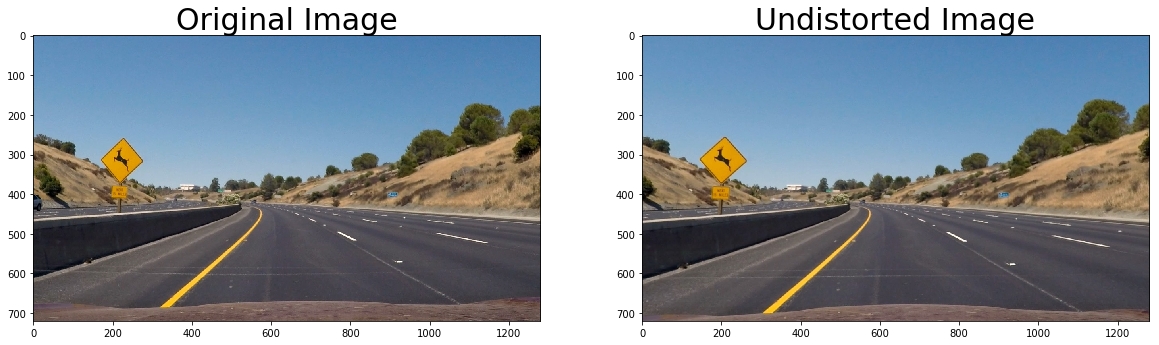

In [6]:
# laneImage = mpimg.imread('./test_images/sampleTest.jpg')
laneImage = mpimg.imread('./test_images/test2.jpg')

undistortImage = undistort(laneImage)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(laneImage)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistortImage)
ax2.set_title('Undistorted Image', fontsize=30)

laneImage_undistort = cv2.cvtColor(undistortImage, cv2.COLOR_BGR2RGB)
cv2.imwrite('output_images/undist_laneImage.jpg', laneImage_undistort)

#### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.
I used a combination of color and gradient thresholds to generate a binary image (thresholding steps at below cell).

In [7]:
def threshold_binary(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    h_channel = hls[:,:,0]
    s_channel = hls[:,:,2]
    r_channel = img[:,:,0]
    # Sobel x
    
    sobelx = cv2.Sobel(r_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Threshold dir
    h_sobelx = cv2.Sobel(h_channel, cv2.CV_64F, 1, 0, ksize=5)
    h_sobely = cv2.Sobel(h_channel, cv2.CV_64F, 0, 1, ksize=5)

    absgraddir = np.arctan2(np.absolute(h_sobely), np.absolute(h_sobelx))
    h_binary =  np.zeros_like(absgraddir)
    h_binary[(absgraddir >= sx_thresh[0]) & (absgraddir <= sx_thresh[1])] = 1
    
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack((h_binary, sxbinary, s_binary))
    
    # Combine the binary
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(h_binary == 1) | (s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

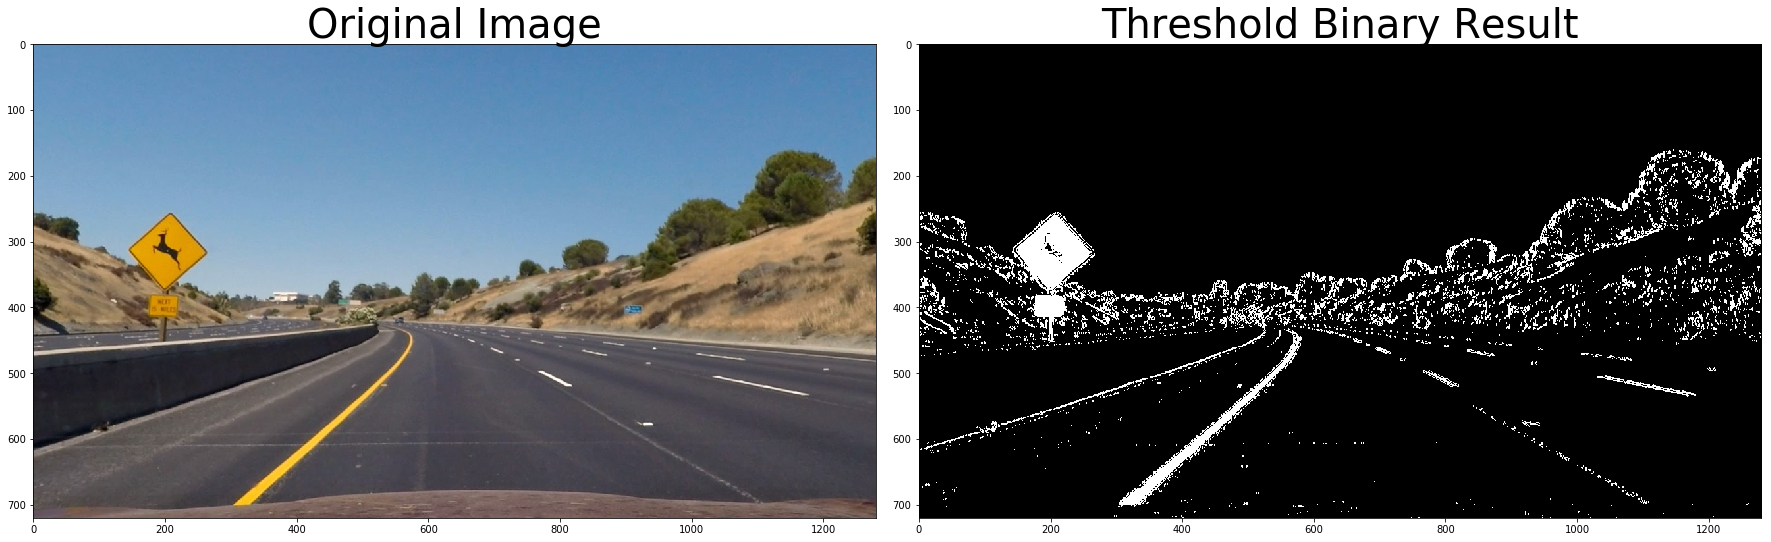

In [8]:
    
threshold_binary_image = threshold_binary(laneImage_undistort)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undistortImage)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(threshold_binary_image, cmap='gray')
ax2.set_title('Threshold Binary Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


#### 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

The code for my perspective transform includes a function called `perspective_transform()` in the below cell. The `perspective_transform()` function takes as inputs an image (`img`), as well as source (`src`) and destination (`dst`) points.  I chose the hardcode the source and destination points in the following manner:

```
src = np.float32(
    [[(img_size[0] / 2) - 60, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 60), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

```
This resulted in the following source and destination points:

| Source        | Destination   | 
|:-------------:|:-------------:| 
| 580, 460      | 320, 0        | 
| 203, 720      | 320, 720      |
| 1127, 720     | 960, 720      |
| 700, 460      | 960, 0        |

I verified that my perspective transform was working as expected by drawing the `src` and `dst` points onto a test image and its warped counterpart to verify that the lines appear parallel in the warped image.


In [9]:
def perspective_transform(image, src, dst):
    img_size = (image.shape[1], image.shape[0])

    # Compute the perspective transform, M
    M = cv2.getPerspectiveTransform(src, dst)

    # Crate warped image - users liner interpolation
    return cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)

True

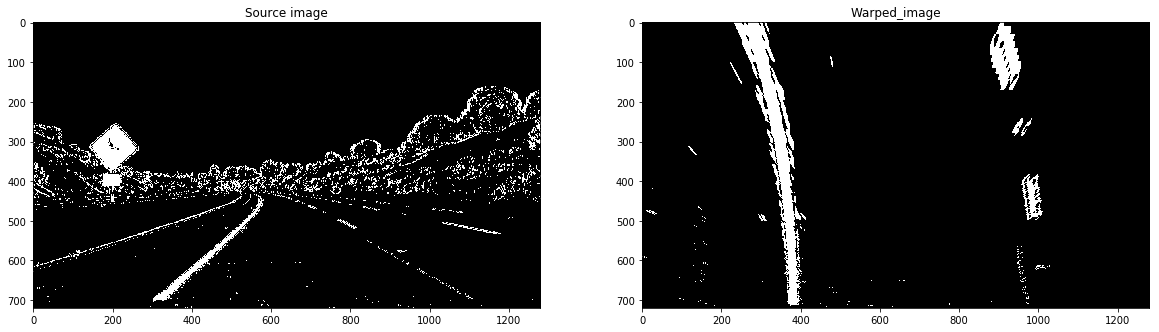

In [10]:

# Get perspective transform
perspective_transformed_image = perspective_transform(threshold_binary_image, src, dst)

# Visulize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.set_title('Source image')
ax1.imshow(threshold_binary_image, cmap='gray')
ax2.set_title('Warped_image')
ax2.imshow(perspective_transformed_image, cmap='gray')

warped_output = cv2.cvtColor(perspective_transformed_image, cv2.COLOR_GRAY2RGB)
cv2.imwrite('./output_images/warped.jpg', warped_output)

#### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

Then I calculated the pixel histogram, find the spike and find a 2nd order polynomial kinda like this:


In [11]:
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def find_window_centroids(warped, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

def get_window_centerY():
    return [680, 600, 520, 440, 360, 280, 200, 120, 40]

def prepare_for_plot(binary_warped):
    window_centroids = find_window_centroids(binary_warped, window_width, window_height, margin)
    left_centerX, right_centerX = zip(*window_centroids)
    centerY = get_window_centerY()

    left_fit = np.polyfit(centerY, left_centerX, 2)
    right_fit = np.polyfit(centerY, right_centerX, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_fitx, right_fitx, ploty

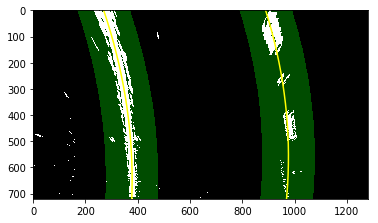

In [12]:
def display_plot(binary_warped, left_fitx, right_fitx, ploty):
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

left_fitx, right_fitx, ploty = prepare_for_plot(perspective_transformed_image)
display_plot(perspective_transformed_image, left_fitx, right_fitx, ploty)

#### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

After I got the points on the line, then I use `curvature()` to calculte the curvature of the lane

In [13]:
def curvature(leftx, rightx, ploty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    
    return left_curverad, right_curverad

In [14]:
left_curv, right_curv = curvature(left_fitx, right_fitx, ploty)
print(left_curv,right_curv)

# Example values: 632.1 m    626.2 m

632.294640557 587.990308609


#### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

I use `draw_green_line()` to plot back the previous step on the image.  Here is an example of my result on a test image:

In [15]:
def draw_green_line(warped, undist, Minv, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result

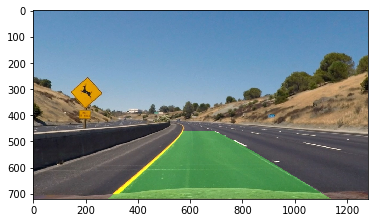

In [16]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

Minv = cv2.getPerspectiveTransform(dst, src)
result = draw_green_line(perspective_transformed_image, undistortImage, Minv, left_fitx, right_fitx, ploty)
plt.imshow(result)

### Pipeline (video)

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

Here's a [link to my video result](./project_video.mp4)

In [57]:
pipe_line_output = "pipeLineOutput.mp4"
clip1 = VideoFileClip("project_video.mp4")
pipe_line_output_clip = clip1.fl_image(process_image)
%time pipe_line_output_clip.write_videofile(pipe_line_output, audio=False)



[MoviePy] >>>> Building video pipeLineOutput.mp4
[MoviePy] Writing video pipeLineOutput.mp4


100%|█████████▉| 1260/1261 [03:33<00:00,  5.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: pipeLineOutput.mp4 

CPU times: user 4min 12s, sys: 39.4 s, total: 4min 52s
Wall time: 3min 34s


### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

During the observation, it seems the pipeline will fail from 22 - 24 seconds and 39 - 41 seconds where a different type of road will be presented. 

There is a high chance for the yellow line being thresholded.

Potential rectification would be to implement memory based search and only search the lane line based on known lane line area.